In [3]:
import sys
sys.path.append('../')
from src.evaluation.goal_evaluator import GoalEvaluator
from src.extraction.extractor import generate_description, generate_actors, generate_high_level_goals, generate_low_level_goals
from src.mapping.APIs_mapping import generate_mapping_apis_goals, print_api_goal_mapping
from src.self_critique.refine_response import EvalMode, generate_response_with_reflection
from src.utils import get_api_list_from_swagger
from src.examples.shot_learning import ShotPromptingMode

# Experiments

In [4]:
SHOTS_NUMBER = ShotPromptingMode.FEW_SHOT

### Description Generation

In [5]:
print("Description STARTING...")
description = generate_description("https://github.com/WebFuzzing/EMB/tree/master/jdk_8_maven/cs/rest-gui/genome-nexus#readme")
print("Description DONE...")
print(description)

Description STARTING...
Description DONE...
description='Genome Nexus is a comprehensive resource designed for the fast and automated annotation and interpretation of genetic variants in cancer. It integrates data from various existing databases, facilitating the conversion of DNA changes to protein changes, predicting the functional effects of protein mutations, and providing insights on mutation frequencies, gene functions, variant impacts, and clinical actionability. This project aims to streamline the process of understanding genetic alterations, which is crucial for research and clinical applications in oncology.'


### Actors Extraction

In [6]:
actors, actors_score, actors_critique = generate_response_with_reflection(
    "Actors",
    generate_actors,
    define_args=description,
    eval_mode=EvalMode.ACTORS,
    eval_args=description,
    shotPromptingMode=SHOTS_NUMBER,
    max_attempts=3
)

Actors STARTING... (attempt 1)
No feedback provided!
Actors DONE...
actors=[Actor(name='Researchers', description='Individuals conducting studies and experiments related to genetic variants.'), Actor(name='Clinical Oncologists', description='Medical professionals utilizing genetic data to inform treatment decisions for cancer patients.'), Actor(name='Bioinformaticians', description='Experts in analyzing genetic data and interpreting results for clinical use.'), Actor(name='Laboratory Technicians', description='Personnel involved in testing and processing genetic samples.'), Actor(name='Data Integrators', description='Individuals responsible for managing and integrating data from various databases.')]
Evaluation for Actors STARTING...
Evaluation for Actors DONE...
Score: 8
Critique: The actors identified seem to be relevant to the Genome Nexus project, covering various roles involved in genetic variant annotation and interpretation. However, the description could be improved by consider

### High Level Goals Extraction

In [7]:
highLevelGoals, HL_score, HL_critique = generate_response_with_reflection(
    "High Level Goals",
    generate_high_level_goals,
    define_args=(description, actors),
    eval_mode=EvalMode.HIGH_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors)
)

High Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant expert in software engineering tasks You're tasked with extracting high level goals from a software description for each provided actor that is expected to interact with the software. MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end users of the software.
High Level Goals DONE...
goals=[HighLevelGoal(name='Automate Genetic Variant Annotation', description='Researchers aim to automate the annotation of genetic variants to enhance the efficiency of studies and experiments.', actor=Actor(name='Researchers', description='Individuals conducting studies and experiments related to genetic variants.')), HighLevelGoal(name='Inform Treatment Decisions', description='Clinical oncologists seek to utilize genetic data to make informed treatment decisions for cancer patients.', actor=Actor(name='

### Low Level Goals Extraction

In [8]:
lowLevelGoals, LL_score, LL_critique = generate_response_with_reflection(
    "Low Level Goals",
    generate_low_level_goals,
    define_args=(highLevelGoals),
    eval_mode=EvalMode.LOW_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors, highLevelGoals)
)

Low Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant expert in software engineering tasksElicit low-level goals for a specific stakeholder in a software project  The low-level goals that you create MUST be structured to match against a set of API calls. Don't be too generic, for example, avoid goals like 'make the software fast', 'develop a web interface' etc.Each low-level goal MUST be phrased as an interaction with the system that could be implemented via an API call.Avoid generic goals like 'Access genetic data'. Instead, break them down into atomic actions linked to system capabilities.
Low Level Goals DONE...
low_level_goals=[LowLevelGoal(name='Submit genetic variant data for automated annotation', description='Allow researchers to input genetic variant information for processing and annotation.', high_level_associated=HighLevelGoal(name='Automate Genetic Variant Annotation', description='Researchers aim to aut

### APIs Extraction from Swagger

In [9]:
print("API List STARTING...")
apiList = get_api_list_from_swagger()
print("API List DONE...")
print(apiList)

API List STARTING...
API List DONE...
[API(api_name='fetchVariantAnnotationPOST', api_path='/annotation', description='Retrieves VEP annotation for the provided list of variants', request_type='post'), API(api_name='fetchVariantAnnotationByIdPOST', api_path='/annotation/dbsnp/', description='Retrieves VEP annotation for the provided list of dbSNP ids', request_type='post'), API(api_name='fetchVariantAnnotationByIdGET', api_path='/annotation/dbsnp/{variantId}', description='Retrieves VEP annotation for the give dbSNP id', request_type='get'), API(api_name='fetchVariantAnnotationByGenomicLocationPOST', api_path='/annotation/genomic', description='Retrieves VEP annotation for the provided list of genomic locations', request_type='post'), API(api_name='fetchVariantAnnotationByGenomicLocationGET', api_path='/annotation/genomic/{genomicLocation}', description='Retrieves VEP annotation for the provided genomic location', request_type='get'), API(api_name='fetchVariantAnnotationGET', api_path=

### APIs Mapping to Low Level Goals

In [10]:
print("Mapping STARTING...")
mappings = generate_mapping_apis_goals(lowLevelGoals, apiList)
print("Mapping DONE")

Mapping STARTING...
hlg name:  Automate Genetic Variant Annotation
Goal name:  Submit genetic variant data for automated annotation
Goal description:  Allow researchers to input genetic variant information for processing and annotation.
APIs:  fetchVariantAnnotationPOST, fetchVariantAnnotationByGenomicLocationPOST, fetchVariantAnnotationByIdPOST

hlg name:  Automate Genetic Variant Annotation
Goal name:  Retrieve annotated genetic variant reports
Goal description:  Enable researchers to fetch reports containing automated annotations for submitted genetic variants.
APIs:  fetchVariantAnnotationPOST, fetchVariantAnnotationGET, (Not applicable with the current set of APIs)

hlg name:  Inform Treatment Decisions
Goal name:  Access genetic variant data to inform treatment plans
Goal description:  Clinical oncologists can access specific genetic variant information for patient treatment decisions.
APIs:  fetchVariantAnnotationGET, fetchVariantAnnotationPOST, fetchVariantAnnotationByIdGET

hl

In [11]:
print(mappings[0].low_level_goal.high_level_associated.name)

Automate Genetic Variant Annotation


### Mapping Table

In [12]:
print_api_goal_mapping(mappings)

╒═════════════════════════════════════════╤══════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ High-Level Goal name                    │ Low-Level Goal name                                              │ Low-Level Goal description                                                                                         │ Mapped APIs                                                                                                         │
╞═════════════════════════════════════════╪══════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════════════════════════════

# Evaluation

### Evaluation: Extracted High Level Goals 

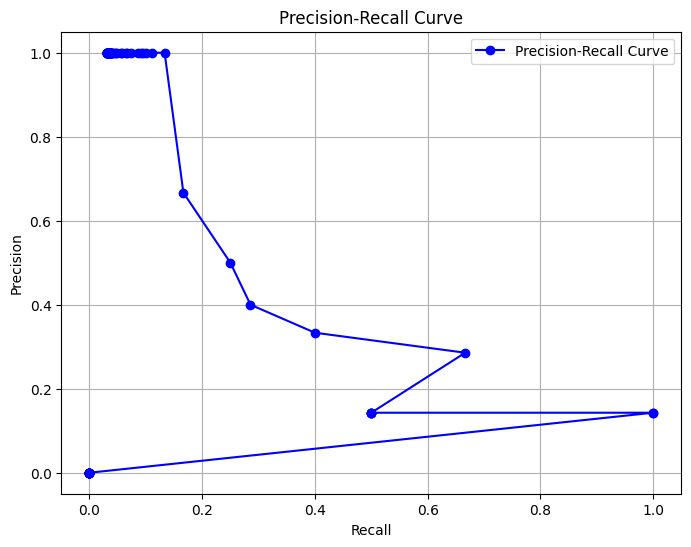

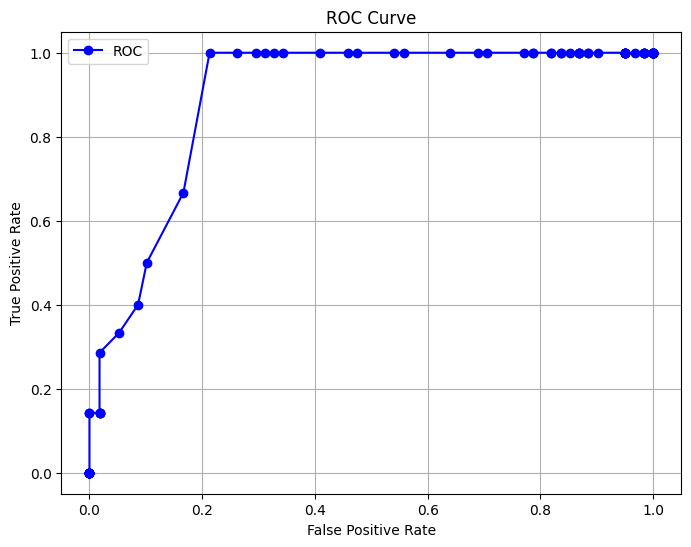

High Level ROC AUC: 0.8960872678551594
High Level Precision Recall Curve AUC: 0.314523809283941


In [13]:
# List of high-level goals 
generated_goals = [goal.description for goal in highLevelGoals.goals]
manual_goals = ["Provide fast and automated annotation of genetic variants", "Enable high-throughput interpretation of genetic variants", "Integrate information from various existing resources", "Convert DNA changes to protein changes", "Predict functional effects of protein mutations", "Provide information about mutation frequencies", "Offer insights into gene function", "Detail variant effects", "Highlight clinical actionability of variants"]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_goals, manual_goals)
print("High Level ROC AUC:", auc_roc)
print("High Level Precision Recall Curve AUC:", auc_prec_rec)


### Evaluation: Extracted Low Level Goals 

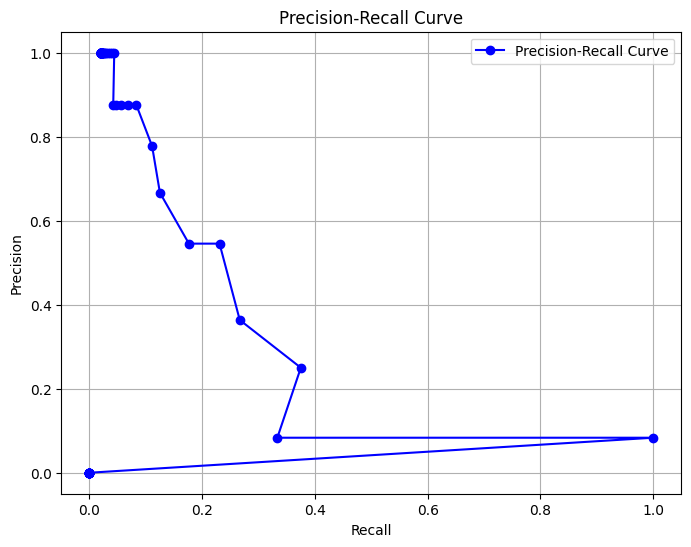

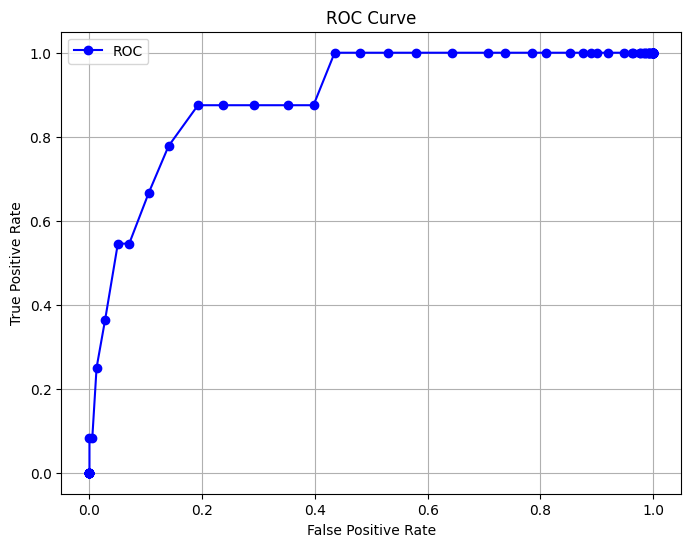

Low Level Goals ROC AUC: 0.8966257392311516
Low Level Goals Precision Recall Curve AUC: 0.22859740701484177


In [14]:
# List of low-level goals 
generated_low_level_goals = [goal.description for goal in lowLevelGoals.low_level_goals]

manual_low_level_goals = [
    # Provide a comprehensive one-stop resource for genetic variant annotation
    "Retrieve genetic variant data from multiple databases (e.g., dbSNP, ClinVar, COSMIC)",
    "Search and retrieve variant annotations from a user interface",
    "Annotate variants with clinical significance, mutation types, and related diseases",
    "Map genetic data to genome assemblies (e.g., GRCh38, hg19)",
    "Update variant information regularly from authoritative sources",
    
    # Enable fast and automated interpretation of cancer-related genetic variants
    "Analyze cancer-related mutations using automated tools",
    "Integrate gene expression data for cancer variant interpretation",
    "Identify cancer-related mutations linked to specific pathways",
    "Interpret large-scale cancer mutation datasets automatically",
    "Classify cancer mutations based on clinical relevance",
    
    # Support high-throughput analysis of genetic mutations
    "Process large genomic datasets in parallel",
    "Extract and transform mutation data from high-throughput sequencing formats (e.g., VCF, BAM)",
    "Perform mutation quality control and filtering",
    
    # Integrate data from multiple genomic databases
    "Fetch and harmonize data from various genomic databases",
    "Query integrated genomic databases for relevant mutation information",
    "Integrate multiple data sources with compatible formats for easy retrieval",
    
    # Convert DNA changes to corresponding protein changes
    "Map genetic mutations to corresponding protein-coding effects",
    "Convert mutations to amino acid changes for protein function analysis",
    "Predict the impact of mutations on protein structure using bioinformatics tools",
    
    # Predict the functional impact of protein mutations
    "Use prediction tools (e.g., PolyPhen, SIFT) to estimate mutation effects on protein function",
    "Build and apply machine learning models for functional impact prediction",
    "Rank mutations based on predicted severity of functional impact",
    
    # Provide information on mutation frequencies across datasets
    "Calculate mutation frequencies across various population groups",
    "Generate visual representations of mutation frequencies (e.g., histograms, pie charts)",
    "Provide mutation frequency data for specific diseases or conditions",
    
    # Offer insights into gene function and biological relevance
    "Retrieve gene function annotations from public databases like Gene Ontology (GO)",
    "Identify pathways and biological processes related to the mutated gene",
    "Link genetic variants to specific diseases or phenotypes based on annotations",
    
    # Detail the effects of genetic variants on protein function
    "Predict the effects of mutations on protein folding and stability",
    "Identify how mutations alter protein activity or structure",
    "Evaluate the impact of mutations on protein-protein interactions",
    
    # Highlight the clinical actionability of specific mutations
    "Link genetic mutations to clinical guidelines or treatment protocols",
    "Identify mutations with known clinical drug responses or therapeutic implications",
    "Provide actionable insights on mutations based on current clinical research"
]

evaluator_low_level = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator_low_level.print_roc_prec_rec_curve(generated_low_level_goals, manual_low_level_goals)
print("Low Level Goals ROC AUC:", auc_roc)
print("Low Level Goals Precision Recall Curve AUC:", auc_prec_rec)

### Evaluation: Extracted Actors 

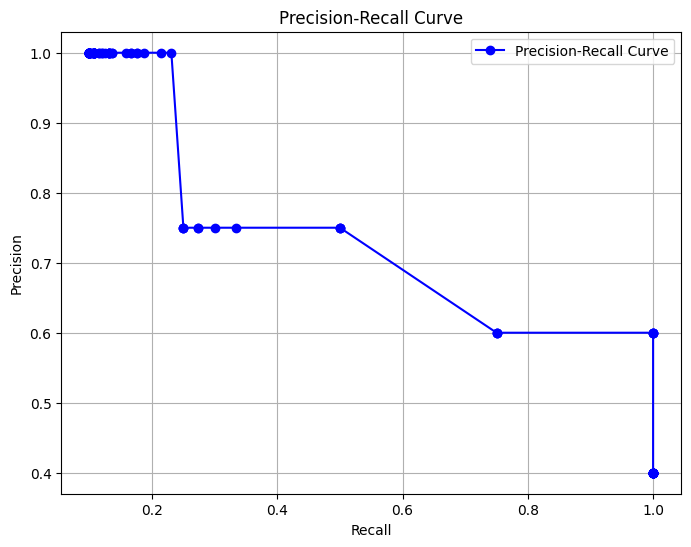

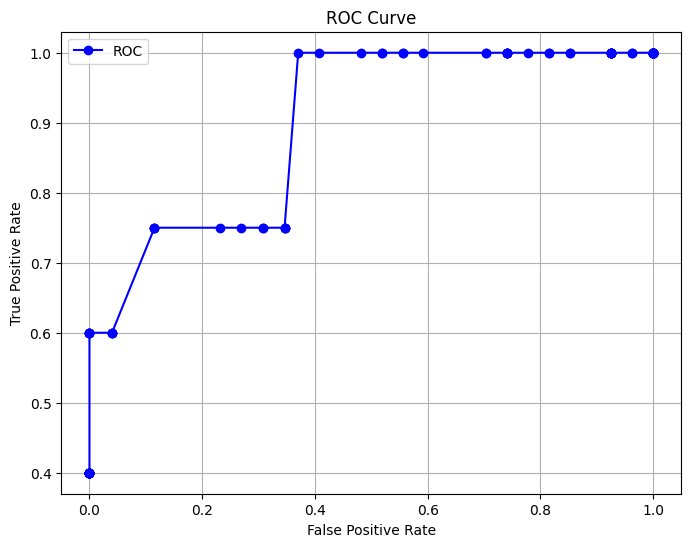

Actors ROC AUC: 0.898780626471579
Actors Precision Recall Curve AUC: 0.35384615362044125


In [15]:
# List of actors
generated_actors = [actor.name for actor in actors.actors]
manual_actors = [
    "Researchers", "Clinicians", "biologists", "Database Administrators", "Bioinformaticians", "Geneticists"
]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_actors, manual_actors)
print("Actors ROC AUC:", auc_roc)
print("Actors Precision Recall Curve AUC:", auc_prec_rec)